<a href="https://colab.research.google.com/github/Rhythm1821/Tensorflow-Face-Detection/blob/main/Face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Detection Tensorflow

## 1 Setup and Data gathering

### 1.1 Install dependencies

In [1]:
pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [2]:
pip install albumentations

In [3]:
# !pip install labelme
# import labelme

### 1.2 Collect images using opencv

In [4]:
import os, uuid,time,cv2

In [5]:
# Create data folder
if not os.path.exists('data'):
  os.mkdir('data')

# if not os.path.exists('/content/data/images'):
#   os.mkdir('/content/data/images')
# if not os.path.exists('/content/data/labels'):
#   os.mkdir('/content/data/labels')

In [6]:
"""
Take images by running this in your local to get your images
IMAGES_PATH = os.path.join('content','data','images')
number_images = 30
cap = cv2.VideoCapture(0)
for img_num in range(number_images):
  print(f'Collecting image {img_num}')
  ret, frame = cap.read()
  imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
  cv2.imwrite(imgname,frame)
  cv2.imshow('frame',frame)
  time.sleep(0.5)

  if cv2.waitKey(1) & 0xFF==ord('q'):
    break

cap.release()
cv2.destroyAllWindows()]
"""

"\nTake images by running this in your local to get your images\nIMAGES_PATH = os.path.join('content','data','images')\nnumber_images = 30\ncap = cv2.VideoCapture(0)\nfor img_num in range(number_images):\n  print(f'Collecting image {img_num}')\n  ret, frame = cap.read()\n  imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')\n  cv2.imwrite(imgname,frame)\n  cv2.imshow('frame',frame)\n  time.sleep(0.5)\n\n  if cv2.waitKey(1) & 0xFF==ord('q'):\n    break\n\ncap.release()\ncv2.destroyAllWindows()]\n"

In [7]:
from zipfile import ZipFile
import requests
from pathlib import Path

data_path = Path('data/')
image_path = Path(data_path / 'images')
label_path = Path(data_path / 'labels')

if data_path.is_dir():
  print(f'{data_path} path already exists...')
else:
  print(f'Creating {data_path} path')
  data_path.mkdir(parents=True,exist_ok=True)

with open('images.zip','wb') as f:
  request = requests.get('https://github.com/Rhythm1821/Colab-Project-Data/raw/main/Face-Detection/images.zip')
  f.write(request.content)

with ZipFile('images.zip','r') as zip_ref:
  print('unzipping the data......')
  zip_ref.extractall(data_path)

with open('labels.zip','wb') as f:
  request = requests.get('https://github.com/Rhythm1821/Colab-Project-Data/raw/main/Face-Detection/labels.zip')
  f.write(request.content)

with ZipFile('labels.zip','r') as zip_ref:
  print('unzipping the data......')
  zip_ref.extractall(data_path)


data path already exists...
unzipping the data......
unzipping the data......


## 2 Review dataset and build image loading function

### 2.1 Import tf and Deps

In [8]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt

In [9]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### 2.2 Load images into a tf data pipeline

In [10]:
images = tf.data.Dataset.list_files('/content/data/images/*.jpg')

In [11]:
images.as_numpy_iterator().next()

b'/content/data/images/1caa6635-335f-11ee-b4df-3534da5cf7d2.jpg'

In [12]:
def load_image(x):
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [13]:
images = images.map(load_image)

In [14]:
# images.as_numpy_iterator().next()

In [15]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.3 View raw images with Matplotlib

In [16]:
image_generator = images.batch(4).as_numpy_iterator() #batches images

In [17]:
plot_images = image_generator.next()

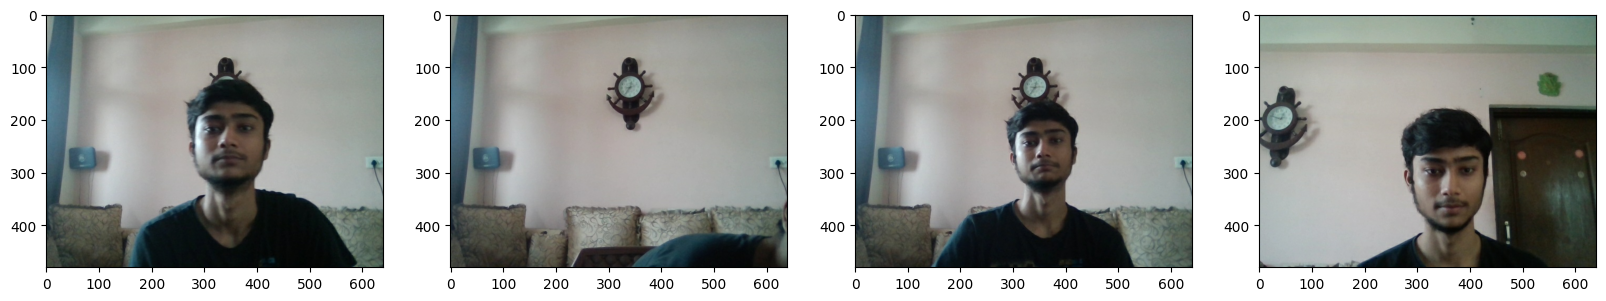

In [18]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, image in enumerate(plot_images):
  ax[idx].imshow(image)
plt.show()

In [19]:
# # os.mkdir('data')
# train_path = Path('data/train')
# train_path.mkdir()
# test_path = Path('data/test')
# test_path.mkdir()
# val_path = Path('data/val')
# val_path.mkdir()
# Path(train_path/'images').mkdir()
# Path(train_path/'labels').mkdir()
# Path(test_path/'images').mkdir()
# Path(test_path/'labels').mkdir()
# Path(val_path/'images').mkdir()
# Path(val_path/'labels').mkdir()

## 3 Partition unaugmentated data

### 3.1 Manually split data into train, test, val

In [20]:
import os
import shutil
import random
import json

data_dir = '/content/data/'
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Create the train, val, and test subdirectories
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

os.makedirs(os.path.join(train_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'labels'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'labels'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'labels'), exist_ok=True)

# Get a list of image files and label files
image_dir = os.path.join(data_dir, 'images')
label_dir = os.path.join(data_dir, 'labels')

image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
label_files = [f for f in os.listdir(label_dir) if f.endswith('.json')]

# Shuffle the files while maintaining the correspondence between images and labels
random.seed(42)
random.shuffle(image_files)
random.seed(42)
random.shuffle(label_files)

# Split the data
# for images
num_images = len(image_files)
num_train = int(train_ratio * num_images)
num_val = int(val_ratio * num_images)

# for labels
num_labels = len(label_files)
num_labeltrain = int(train_ratio * num_labels)
num_labelval = int(val_ratio * num_labels)

train_image_files = image_files[:num_train]
val_image_files = image_files[num_train:num_train + num_val]
test_image_files = image_files[num_train + num_val:]

train_label_files = label_files[:num_labeltrain]
val_label_files = label_files[num_labeltrain:num_labeltrain + num_labelval]
test_label_files = label_files[num_labeltrain + num_labelval:]

# Move the images and labels to their respective folders in train, val, and test
def move_files(source_dir, dest_dir, files):
    for file in files:
        source_path = os.path.join(source_dir, file)
        dest_path = os.path.join(dest_dir, file)
        shutil.move(source_path, dest_path)

# Move images and labels to their respective folders for train, val, and test sets
move_files(image_dir, os.path.join(train_dir,'images'), train_image_files)
move_files(label_dir, os.path.join(train_dir,'labels'), train_label_files)

move_files(image_dir, os.path.join(val_dir,'images'), val_image_files)
move_files(label_dir, os.path.join(val_dir,'labels'), val_label_files)

move_files(image_dir, os.path.join(test_dir,'images'), test_image_files)
move_files(label_dir, os.path.join(test_dir,'labels'), test_label_files)

print("Data split and stored in their respective folders.")


Data split and stored in their respective folders.


## 4 Apply Image augmentation on images and labels using alubmentations

### 4.1 Setup albumentations transform pipeline

In [21]:
import albumentations as alb

In [121]:
augmentor = alb.Compose([alb.RandomCrop(width=450,height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))

### 4.2 Load a test image and annotation with OpenCV and json

In [122]:
img_path = os.path.join('/content','data','train','images','1948933b-335f-11ee-b4df-3534da5cf7d2.jpg')
img = cv2.imread(img_path)

In [123]:
label_path = os.path.join('/content','data','train','labels','1948933b-335f-11ee-b4df-3534da5cf7d2.json')

In [124]:
label_path,img_path

('/content/data/train/labels/1948933b-335f-11ee-b4df-3534da5cf7d2.json',
 '/content/data/train/images/1948933b-335f-11ee-b4df-3534da5cf7d2.jpg')

In [125]:
with open(label_path,'r') as f:
  label = json.load(f)

### 4.3 Extract coordinates and rescale to match image resolution

In [126]:
label['shapes'][0]['points']

[[442.26277372262774, 397.66423357664235], [270.0, 185.98540145985402]]

In [166]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][1][0]
coords[1] = label['shapes'][0]['points'][1][1]
coords[2] = label['shapes'][0]['points'][0][0]
coords[3] = label['shapes'][0]['points'][0][1]

In [167]:
coords #pascal voc format

[270.0, 185.98540145985402, 442.26277372262774, 397.66423357664235]

In [168]:
coords = list(np.divide(coords,[640,480,640,480])) #dividing coords by width(480) and height (640)
coords #albumentation format

[0.421875, 0.38746958637469586, 0.6910355839416058, 0.8284671532846716]

### 4.4 Apply augmentations

In [169]:
augmented = augmentor(image=img,bboxes=[coords],class_labels=['face'])

In [170]:
augmented['image'].shape

(450, 450, 3)

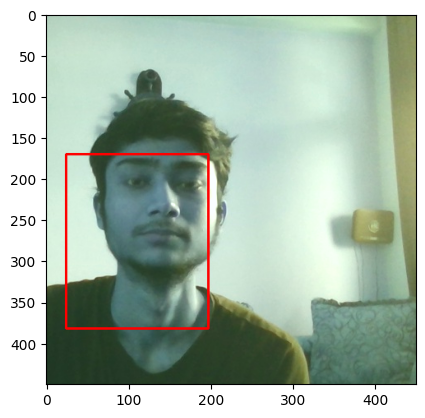

In [171]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
              (255,0,0),2)
plt.imshow(augmented['image'])

## 5 Augmentation pipeline

### 5.1 Run augmentation pipeline

In [154]:
for partition in ['test','train','val']:
  for image in os.listdir(os.path.join('data',partition,'images')):
    img = cv2.imread(os.path.join('data',partition,'images',image))

    coords = [0,0,0.00001,0.00001]
    label_path = os.path.join('data',partition,'labels',f"{image.split('.')[0]}.json")
    if os.path.exists(label_path):
      with open(label_path,'r') as f:
        label = json.load(f)

        coords[0] = label['shapes'][0]['points'][1][0]
        coords[1] = label['shapes'][0]['points'][1][1]
        coords[2] = label['shapes'][0]['points'][0][0]
        coords[3] = label['shapes'][0]['points'][0][1]
        coords = list(np.divide(coords,[640,480,640,480]))
    try:
      for x in range(60):
        # print(img)
        augmented = augmentor(image=img,bboxes=[coords],class_labels='face')
        cv2.imwrite(os.path.join('aug_data',partition,'images',f"{image.split('.')[0]}.{x}.jpg"),augmented['image'])

        annotation = {}
        annotation['image'] = image

        if os.path.exists(label_path):
          if len(augmented['bboxes'])==0:
            annotation['bbox']=[0,0,0,0]
            annotation['class']=0
          else:
            annotation['bbox'] = augmented['bboxes'][0]
            annotation['class'] = 1
        else:
          annotation['bbox'] = [0,0,0,0]
          annotation['class'] = 0

        with open(os.path.join('aug_data',partition,'labels',f"{image.split('.')[0]}.json")) as f:
          json.dump(annotation,f)
    except Exception as e:
      raise e

AssertionError: ignored